# Simulation of noisy mutual inhibition
*Nhat Le, October 2017*

In [79]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

In [148]:
# Common parameters used for the entire file
param_dict_no_theta = {'Wut': 6, 'Wvt': 6, 'Wuv': 6, 'Wvu': 6,
              'theta': 0.6, 'tau': 100, 'dt': 10, 'ext': 0, 'sigma': 0.1}

param_dict_theta = {'Wut': 6, 'Wvt': 6, 'Wuv': 6, 'Wvu': 6,
              'theta': 0.8, 'tau': 100, 'dt': 10, 'ext': 0, 'sigma': 0.1}

state_dict = {'u': 1, 'v': 0}

In [81]:
def thresh_exp(x):
    '''Activation function'''
    return 1 / (1 + np.exp(-x))

def find_u_dot(state, params):
    '''Returns du/dt given the parameters and current state'''
    Wuv = params['Wuv']
    Wut = params['Wut']
    tau = params['tau']
    ext = params['ext']
    theta = params['theta']
    
    u = state['u']
    v = state['v']
    return (-u + thresh_exp(Wut * theta - Wuv * v + ext)) / tau

def find_v_dot(state, params):
    '''Returns dv/dt given the parameters and current state'''
    Wvu = params['Wvu']
    Wvt = params['Wvt']
    tau = params['tau']
    ext = params['ext']
    theta = params['theta']

    
    u = state['u']
    v = state['v']
    return (-v + thresh_exp(Wvt * theta - Wvu * u + ext)) / tau

def update_u_exp(state, params):
    '''Update u based on params'''
    state_new = state.copy()
    state_new['u'] += find_u_dot(state, params) * params['dt']
    return state_new

def update_v_exp(state, params):
    '''Update v based on params'''
    state_new = state.copy()
    state_new['v'] += find_v_dot(state, params) * params['dt']
    return state_new

def simulate_u_v_exp(state_init, params, niter):
    '''Simulate for niter iterations'''
    curr_state = state_init.copy()
    u_lst = [state_init['u']]
    v_lst = [state_init['v']]

    for i in range(niter):
        order = np.random.randint(0, 2)
        if order:
            curr_state = update_u_exp(curr_state, params)    
            curr_state = update_v_exp(curr_state, params)
        else:
            curr_state = update_v_exp(curr_state, params)    
            curr_state = update_u_exp(curr_state, params)
        v_lst.append(curr_state['v'])
        u_lst.append(curr_state['u'])
    return u_lst, v_lst

Fixed point coordinates are:  0.957834758364 0.279486824449


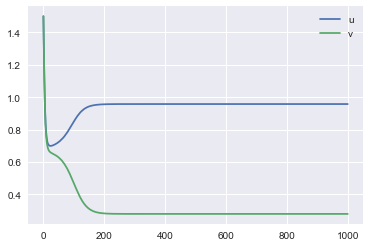

In [82]:
# Find fixed points for high theta
init_dict = {'u': 1.5, 'v': 1.5}
ulst_theta, vlst_theta = simulate_u_v_exp(init_dict, param_dict_theta, niter=1000)
plt.plot(ulst_theta, label='u')
plt.plot(vlst_theta, label='v')
plt.legend()
print('Fixed point coordinates are: ', ulst_theta[-1], vlst_theta[-1])

# Store the fixed points as dictionaries
stable1_theta = {'u': ulst_theta[-1], 'v': vlst_theta[-1]}
stable2_theta = {'v': ulst_theta[-1], 'u': vlst_theta[-1]}

In [138]:
param_dict_no_theta

{'Wut': 6,
 'Wuv': 6,
 'Wvt': 6,
 'Wvu': 6,
 'dt': 10,
 'ext': 0,
 'sigma': 0.1,
 'tau': 100,
 'theta': 0.6}

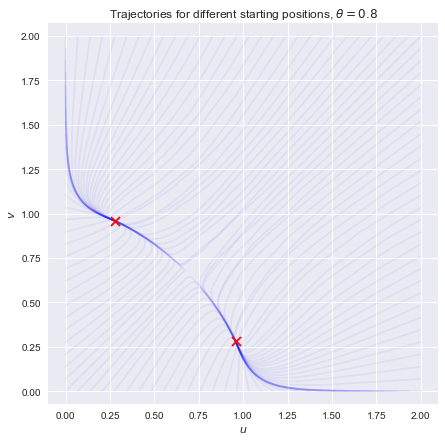

In [149]:
# Find trajectories for various starting points
plt.figure(figsize=(7, 7))
values = np.linspace(0, 2, 30);
for i in values:
    for j in values:
        if i == 0 or j == 0 or i == 2 or j == 2:
            init_dict = {'u': i, 'v': j}
            ulst_theta, vlst_theta = simulate_u_v_exp(init_dict, param_dict_theta, niter=1000)
            plt.plot(ulst_theta, vlst_theta, 'b', alpha=0.05)

# Plot the fixed points
stable1 = ulst_theta[-1]
stable2 = vlst_theta[-1]
plt.scatter([stable1, stable2], [stable2, stable1], color='r', marker='x', s=80, zorder=5)
plt.xlabel(r'$u$')
plt.ylabel(r'$v$')

plt.xlim([0, 2])
plt.axis('equal')
#plt.ylim([0, 2])
plt.title(r'Trajectories for different starting positions, $\theta=0.8$')
#plt.savefig('trajectories_0_8_theta.pdf')

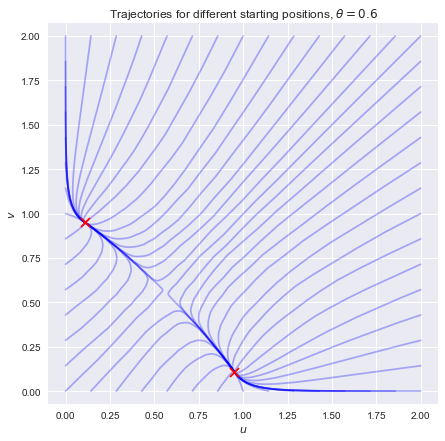

In [141]:
# Find trajectories for various starting points
plt.figure(figsize=(7, 7))
values = np.linspace(0, 2, 15);
for i in values:
    for j in values:
        if i == 0 or j == 0 or i == 2 or j == 2:
            init_dict = {'u': i, 'v': j}
            ulst_theta, vlst_theta = simulate_u_v_exp(init_dict, param_dict_no_theta, niter=1000)
            plt.plot(ulst_theta, vlst_theta, 'b', alpha=0.3)

# Plot the fixed points
stable1 = ulst_theta[-1]
stable2 = vlst_theta[-1]
plt.scatter([stable1, stable2], [stable2, stable1], color='r', marker='x', s=80, zorder=5)
plt.xlabel(r'$u$')
plt.ylabel(r'$v$')

plt.xlim([0, 2])
plt.axis('equal')
#plt.ylim([0, 2])
plt.title(r'Trajectories for different starting positions, $\theta=0.6$')
plt.savefig('trajectories_0_6_theta.pdf')

Fixed point coordinates are:  0.109064286175 0.950055797413


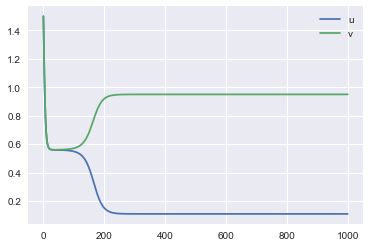

In [84]:
# Find fixed points for low theta
ulst_no_theta, vlst_no_theta = simulate_u_v_exp(init_dict, param_dict_no_theta, niter=1000)
plt.plot(ulst_no_theta, label='u')
plt.plot(vlst_no_theta, label='v')
plt.legend()
print('Fixed point coordinates are: ', ulst_no_theta[-1], vlst_no_theta[-1])

# Store the fixed points as dictionaries
stable1_no_theta = {'u': ulst_no_theta[-1], 'v': vlst_no_theta[-1]}
stable2_no_theta = {'v': ulst_no_theta[-1], 'u': vlst_no_theta[-1]}


In [7]:
def find_path_integral_line(state1, state2, params, nsteps):
    '''Perform the path integral along a straight line from 
    state1 to state2, taking n steps
    Returns the total integral, together with the cumulative list of integrals
    along the path'''
    u_ids = np.linspace(state1['u'], state2['u'], nsteps)
    v_ids = np.linspace(state1['v'], state2['v'], nsteps)
    
    integral, integrals = find_path_integral_list(u_ids, v_ids, params)
        
    return integral, np.array(integrals)
        
    
def find_path_integral_list(u_pos_list, v_pos_list, params):
    '''Perform the path integral along an arbitrary line parameterized by
    u_pos_list and v_pos_list, taking n steps
    Returns the total integral, together with the cumulative list of integrals
    along the path'''    
    # Variables for storage
    integral = 0
    integrals = [0]
    nsteps = len(u_pos_list)
    
    for i in range(nsteps - 1):
        ustart = u_pos_list[i]
        uend = u_pos_list[i + 1]
        vstart = v_pos_list[i]
        vend = v_pos_list[i + 1]
        
        start_state = {'u': ustart, 'v': vstart}
        
        udot = find_u_dot(start_state, params)
        vdot = find_v_dot(start_state, params)
        
        du = uend - ustart
        dv = vend - vstart
        
        integral -= udot * du + vdot * dv
        integrals.append(integral)
        
    return integral, np.array(integrals)
    

In [8]:
stable1arr_theta = np.array([stable1_theta['u'], stable1_theta['v']])
stable2arr_theta = np.array([stable2_theta['u'], stable2_theta['v']])
startpt_theta = stable1arr_theta - 0.1 * (stable2arr_theta - stable1arr_theta)
endpt_theta = stable2arr_theta + 0.1 * (stable2arr_theta - stable1arr_theta)
startpt_dict_theta = {'u': startpt_theta[0], 'v': startpt_theta[1]}
endpt_dict_theta = {'u': endpt_theta[0], 'v': endpt_theta[1]}

stable1arr_no_theta = np.array([stable1_no_theta['u'], stable1_no_theta['v']])
stable2arr_no_theta = np.array([stable2_no_theta['u'], stable2_no_theta['v']])
startpt_no_theta = stable1arr_no_theta - 0.1 * (stable2arr_no_theta - stable1arr_no_theta)
endpt_no_theta = stable2arr_no_theta + 0.1 * (stable2arr_no_theta - stable1arr_no_theta)
startpt_dict_no_theta = {'u': startpt_no_theta[0], 'v': startpt_no_theta[1]}
endpt_dict_no_theta = {'u': endpt_no_theta[0], 'v': endpt_no_theta[1]}

integral_theta_short, integrals_theta_short = find_path_integral_line(stable1_theta, stable2_theta, 
                                                param_dict_theta, 1000)
integral_theta_long, integrals_theta_long = find_path_integral_line(startpt_dict_theta, endpt_dict_theta, 
                                                param_dict_theta, 1000)
integral_notheta_short, integrals_notheta_short = find_path_integral_line(stable1_no_theta, stable2_no_theta, 
                                                param_dict_no_theta, 1000)
integral_notheta_long, integrals_notheta_long = find_path_integral_line(startpt_dict_no_theta, 
                                                endpt_dict_no_theta, param_dict_no_theta, 1000)


difference, _ = find_path_integral_line(startpt_dict_theta, startpt_dict_no_theta, param_dict_theta, 1000)

In [9]:
stable1arr_no_theta

array([ 0.9500558 ,  0.10906429])

In [10]:
startpt_dict_no_theta

{'u': 1.0341549485363988, 'v': 0.024965135051673415}

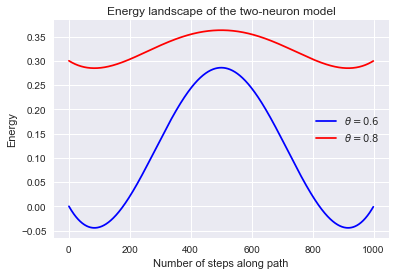

In [11]:
plt.plot(integrals_notheta_long * 1000, 'b', label=r'$\theta=0.6$')
plt.plot(integrals_theta_long * 1000 + 0.3, 'r', label=r'$\theta=0.8$')
plt.xlabel('Number of steps along path')
plt.ylabel('Energy')
plt.title('Energy landscape of the two-neuron model')
plt.legend()
#plt.savefig('energy_landscape.pdf')


## Energy landscapes for various values of $\theta$

In [12]:
integral_set = []
theta_vals = np.linspace(0, 1, 11)
fixed_points = np.zeros((len(theta_vals), 2))
for idx, theta_val in enumerate(theta_vals):
    print('Doing theta = ', theta_val)
    # Create the parameter dictionary
    param_dict_theta_val = {'Wut': 6, 'Wvt': 6, 'Wuv': 6, 'Wvu': 6,
                  'theta': theta_val, 'tau': 100, 'dt': 10, 'ext': 0}
    
    # Do simulation to find fixed points
    # Find fixed points for high theta
    init_dict = {'u': 0.22, 'v': 0.22}
    ulst_theta_val, vlst_theta_val = simulate_u_v_exp(init_dict, param_dict_theta_val, niter=1000)
    
    # Store fixed points
    fixed_points[idx, 0] = ulst_theta_val[-1]
    fixed_points[idx, 1] = vlst_theta_val[-1]
    stable1_theta_val = {'u': ulst_theta_val[-1], 'v': vlst_theta_val[-1]}
    stable2_theta_val = {'v': ulst_theta_val[-1], 'u': vlst_theta_val[-1]}

    # Perform the path integral. First set up relevant starting points
    stable1arr_theta_val = np.array([stable1_theta_val['u'], stable1_theta_val['v']])
    stable2arr_theta_val = np.array([stable2_theta_val['u'], stable2_theta_val['v']])
    startpt_theta_val = stable1arr_theta_val - 0.1 * (stable2arr_theta_val - stable1arr_theta_val)
    endpt_theta_val = stable2arr_theta_val + 0.1 * (stable2arr_theta_val - stable1arr_theta_val)
    startpt_dict_theta_val = {'u': startpt_theta_val[0], 'v': startpt_theta_val[1]}
    endpt_dict_theta_val = {'u': endpt_theta_val[0], 'v': endpt_theta_val[1]}

    # Then do integral...
    _, integrals_theta_val = find_path_integral_line(startpt_dict_theta_val, endpt_dict_theta_val, 
                                                    param_dict_theta_val, 1000)
    integral_set.append(integrals_theta_val)

Doing theta =  0.0
Doing theta =  0.1
Doing theta =  0.2
Doing theta =  0.3
Doing theta =  0.4
Doing theta =  0.5
Doing theta =  0.6
Doing theta =  0.7
Doing theta =  0.8
Doing theta =  0.9
Doing theta =  1.0


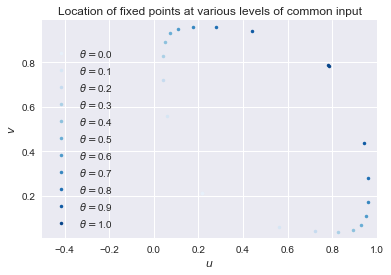

In [13]:
with sns.color_palette("Blues", len(theta_vals)):
    for i in range(len(theta_vals)):
        plt.plot(fixed_points[i, 0], fixed_points[i, 1], '.', 
                 label=r'$\theta=$' + str(theta_vals[i]))

with sns.color_palette("Blues", len(theta_vals)):
    for i in range(len(theta_vals)):
        plt.plot(fixed_points[i, 1], fixed_points[i, 0], '.')
    
# Plot y=x line
xcoords = np.linspace(0, 1, 100)
#plt.plot(xcoords, xcoords, 'k--')

plt.legend(loc='lower left')    
plt.axis('equal');
plt.xlim([-0.5, 1]);
plt.xlabel(r'$u$')
plt.ylabel(r'$v$')
plt.title('Location of fixed points at various levels of common input')
#plt.savefig('fixed_pt_loc.pdf')

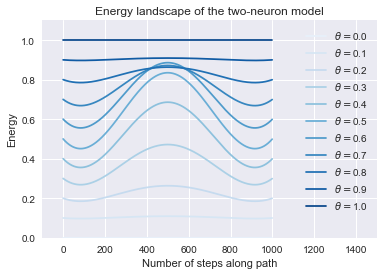

In [14]:
with sns.color_palette("Blues", len(theta_vals)):
    for idx, series in enumerate(integral_set):
        plt.plot(series* 1000 + idx * 0.1, label=r'$\theta=$' + str(theta_vals[idx]))
    plt.xlim(-100, 1500)
    plt.ylim(0, 1.1)
    plt.legend(loc='upper right')
    plt.xlabel('Number of steps along path')
    plt.ylabel('Energy')
    plt.title('Energy landscape of the two-neuron model')

#plt.savefig('energy_landscape_theta.pdf')

In [15]:
def update_u_exp_noise(u, v, c1, c2, c3, theta, tau, dt):
    '''Update neuron u given a noise that is ~N(0, s^2)'''
    noise = np.random.normal(scale=0.01, size=len(u))
    du = (-u + thresh_exp(c3 * theta - c1 * v) + noise) / tau * dt
    return u + du

def update_v_exp_noise(u, v, c1, c2, c3, theta, tau, dt):
    '''Update neuron v given a noise that is ~N(0, s^2)'''
    noise = np.random.normal(scale=0.01, size=len(v))
    dv = (-v + thresh_exp(c3 * theta - c2 * u) + noise) / tau * dt
    return v + dv

def simulate_u_v_exp_noise(u_init, v_init, c1, c2, c3, theta, tau, niter, dt):
    u_lst = []
    v_lst = []
    u = u_init
    v = v_init
    for i in range(niter):
        u = update_u_exp_noise(u, v, c1, c2, c3, theta, tau, dt)
        #print('u = ', u)
        u_lst.append(u)
        v = update_v_exp_noise(u, v, c1, c2, c3, theta, tau, dt)
        #print('v = ', v)
        v_lst.append(v)
    return u_lst, v_lst

## For simultaneous simulation (faster)

In [16]:
def find_u_dot_multi(state, params):
    '''Returns du/dt given the parameters and current state'''
    u = state['u']
    v = state['v']
    Wuv = params['Wuv']
    Wut = params['Wut']
    tau = params['tau']
    ext = params['ext']
    theta = params['theta']
    sigma = params['sigma']
    
    noise = np.random.normal(scale=sigma, size=len(u))
    return (-u + thresh_exp(Wut * theta - Wuv * v + noise)) / tau

def find_v_dot_multi(state, params):
    '''Returns dv/dt given the parameters and current state'''
    u = state['u']
    v = state['v']
    Wvu = params['Wvu']
    Wvt = params['Wvt']
    tau = params['tau']
    ext = params['ext']
    theta = params['theta']
    sigma = params['sigma']
    
    noise = np.random.normal(scale=sigma, size=len(v))
    return (-v + thresh_exp(Wvt * theta - Wvu * u + noise)) / tau

def update_u_exp_multi(state, params):
    '''Update u based on params'''
    state_new = state.copy()
    state_new['u']= state_new['u'] + find_u_dot_multi(state, params) * params['dt']
    return state_new

def update_v_exp_multi(state, params):
    '''Update v based on params'''
    state_new = state.copy()
    state_new['v'] = state_new['v'] + find_v_dot_multi(state, params) * params['dt']
    return state_new

def simulate_u_v_exp_multi(state_init, params, niter):
    '''Simulate for niter iterations'''
    curr_state = state_init.copy()
    u_lst = [state_init['u']]
    v_lst = [state_init['v']]

    for i in range(niter):
        order = np.random.randint(0, 2) # Choose to update u or v first
        if order:
            curr_state = update_u_exp_multi(curr_state, params)
            curr_state = update_v_exp_multi(curr_state, params) 
        else:
            curr_state = update_v_exp_multi(curr_state, params)
            curr_state = update_u_exp_multi(curr_state, params) 
        u_lst.append(curr_state['u'])
        v_lst.append(curr_state['v'])
        
    u_arr = np.vstack(u_lst)
    v_arr = np.vstack(v_lst)
    return u_arr, v_arr

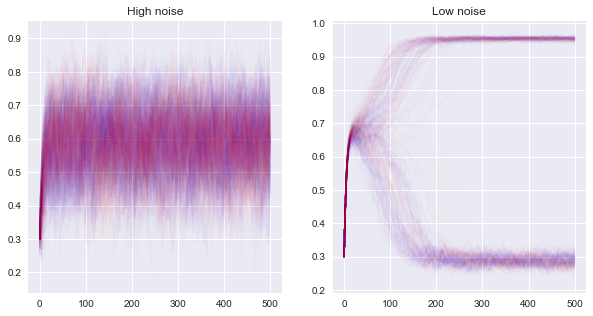

In [61]:
param_dict_theta['sigma'] = 5
state_dict = {'u': np.array([0.3] * 100), 'v': np.array([0.3] * 100)}
ulst_noise, vlst_noise = simulate_u_v_exp_multi(state_dict, param_dict_theta, 500)

param_dict_theta['sigma'] = 0.3
state_dict = {'u': np.array([0.3] * 100), 'v': np.array([0.3] * 100)}
ulst_noise_low, vlst_noise_low = simulate_u_v_exp_multi(state_dict, param_dict_theta, 500)

fig, ax = plt.subplots(1, 2, figsize=(10,5))
ax[0].plot(vlst_noise, 'b', alpha=0.01);
ax[0].plot(ulst_noise, 'r', alpha=0.01);
ax[0].set_title('High noise')

ax[1].plot(vlst_noise_low, 'b', alpha=0.01);
ax[1].plot(ulst_noise_low, 'r', alpha=0.01);
ax[1].set_title('Low noise')

In [62]:
# Plot the mean and std of the distribution
v_means = np.mean(vlst_noise, axis=1)
u_means = np.mean(ulst_noise, axis=1)
v_std = np.std(vlst_noise, axis=1)
u_std = np.std(ulst_noise, axis=1)

v_means_low = np.mean(vlst_noise_low, axis=1)
u_means_low = np.mean(ulst_noise_low, axis=1)
v_std_low = np.std(vlst_noise_low, axis=1)
u_std_low = np.std(ulst_noise_low, axis=1)

(0, 1.2)

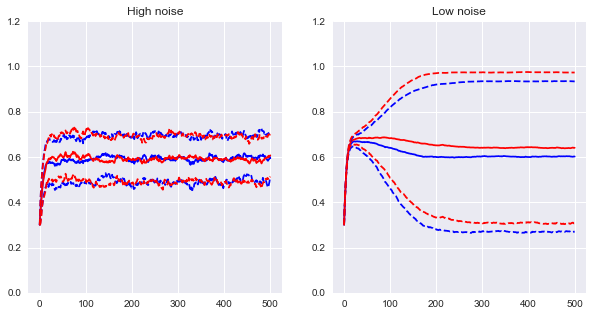

In [63]:
fig, ax = plt.subplots(1, 2, figsize=(10,5))
# High noise
ax[0].plot(v_means, 'b')
ax[0].plot(u_means, 'r')

ax[0].plot(v_means + v_std, 'b--')
ax[0].plot(v_means - v_std, 'b--')
ax[0].plot(u_means + u_std, 'r--')
ax[0].plot(u_means - u_std, 'r--')
ax[0].set_ylim([0, 1.2])
ax[0].set_title('High noise')

# Low noise
ax[1].plot(v_means_low, 'b')
ax[1].plot(u_means_low, 'r')

ax[1].plot(v_means_low + v_std_low, 'b--')
ax[1].plot(v_means_low - v_std_low, 'b--')
ax[1].plot(u_means_low + u_std_low, 'r--')
ax[1].plot(u_means_low - u_std_low, 'r--')
ax[1].set_title('Low noise')
ax[1].set_ylim([0, 1.2])


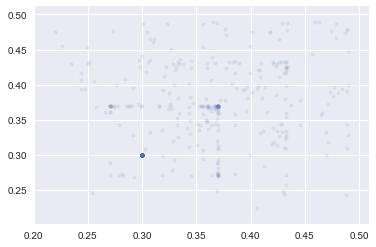

In [64]:
# Cool plot showing the position after the first 4 steps of the simulation
plt.scatter(np.ravel(ulst_noise[0:4,:]), np.ravel(vlst_noise[0:4,:]), marker='.', alpha=0.1);

## Visualize the trajectory at different starting points

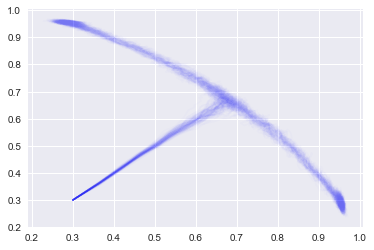

In [65]:
for i in range(ulst_noise_low.shape[1]):
    plt.plot(ulst_noise_low[:,i], vlst_noise_low[:,i], 'b', alpha=0.01)

In [68]:
param_dict_theta_val = {'Wut': 6, 'Wvt': 6, 'Wuv': 6, 'Wvu': 6,
                  'theta': theta_val, 'tau': 100, 'dt': 10, 'ext': 0, 'sigma': 0.3}
state_dict = {'u': np.array([0.7] * 100), 'v': np.array([0.9] * 100)}
ulst_noise_alt, vlst_noise_alt = simulate_u_v_exp_multi(state_dict, param_dict_theta, 500)


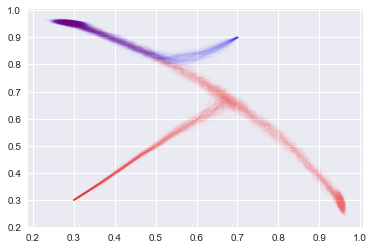

In [69]:
for i in range(ulst_noise_alt.shape[1]):
    plt.plot(ulst_noise_alt[:,i], vlst_noise_alt[:,i], 'b', alpha=0.01)
    
for i in range(ulst_noise_low.shape[1]):
    plt.plot(ulst_noise_low[:,i], vlst_noise_low[:,i], 'r', alpha=0.01)

In [76]:
thresh = 0.6
ulst_uwin_trials = ulst_noise_low[:,ulst_noise_low[-1,:] > thresh]
ulst_vwin_trials = ulst_noise_low[:,ulst_noise_low[-1,:] < thresh]

vlst_uwin_trials = vlst_noise_low[:,ulst_noise_low[-1,:] > thresh]
vlst_vwin_trials = vlst_noise_low[:,ulst_noise_low[-1,:] < thresh]

ulst_uwin_ave = np.mean(ulst_uwin_trials, axis=1)
ulst_vwin_ave = np.mean(ulst_vwin_trials, axis=1)
vlst_uwin_ave = np.mean(vlst_uwin_trials, axis=1)
vlst_vwin_ave = np.mean(vlst_vwin_trials, axis=1)


In [75]:
ulst_vwin_trials.shape

(501, 47)

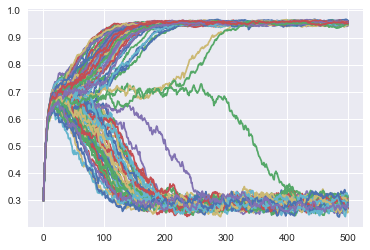

In [54]:
plt.plot(ulst_noise_low);

uwin_trials = 

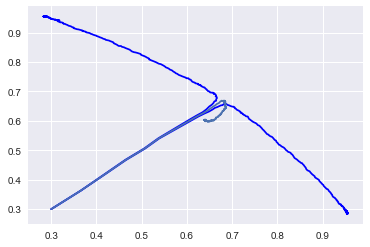

In [78]:
ulst_noise_alt_ave = np.mean(ulst_noise_alt, axis=1)
vlst_noise_alt_ave = np.mean(vlst_noise_alt, axis=1)
plt.plot(ulst_uwin_ave, vlst_uwin_ave, 'b')
plt.plot(ulst_vwin_ave, vlst_vwin_ave, 'b')

ulst_noise_low_ave = np.mean(ulst_noise_low, axis=1)
vlst_noise_low_ave = np.mean(vlst_noise_low, axis=1)
plt.plot(ulst_noise_low_ave, vlst_noise_low_ave)